In [1]:
import pandas as pd

In [2]:
cols = ['location', 'date', 'total_cases', 'new_cases']
dates = ['date']
df = pd.read_csv("csv/owid-covid-data.csv", 
                 usecols=cols,
                 parse_dates=dates)
df.sample()

,location,date,total_cases,new_cases
5930,Indonesia,2020-03-17,134,17


In [3]:
COUNTRIES = ['India', 'China', 'Italy', 'Spain', 'Germany', 'France']

In [4]:
# consider days when total_cases exceeded 100
fdf = df.loc[df['total_cases']>100]

# filter selected countries
# fdf = fdf.loc[fdf['location'].isin(COUNTRIES)]    

In [13]:
def plot_country(df, country='India'):
    grp_df = df.loc[df['location']==country]
    grp_df = grp_df.sort_values(by='date')
    grp_df.reset_index(inplace=True, drop=True)
    grp_df['avg_new_cases'] = grp_df['new_cases'].rolling(7).mean()
    grp_df['change_in_new_cases'] = (grp_df['avg_new_cases'] - grp_df['avg_new_cases'].shift(7)) / 7
    
    ax1 = grp_df.plot(x='date', y='total_cases', grid=True, title='Total cases: ' + country, figsize=(6,3))
    ax2 = grp_df.plot(x='date', y='new_cases', title='Daily cases: ' + country, figsize=(6,3))
    grp_df.plot(x='date', y='avg_new_cases', grid=True, title='Daily cases: ' + country, ax=ax2)
    ax3 = grp_df.plot(x='date', y='change_in_new_cases', grid=True, title="Change in daily cases: " + country, figsize=(6,3))
    ax3.axhline(y=0, linewidth=2, color='r')
    
#     print(len(grp_df.loc[grp_df['change_in_new_cases']==0]))

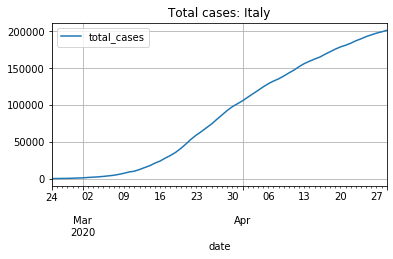

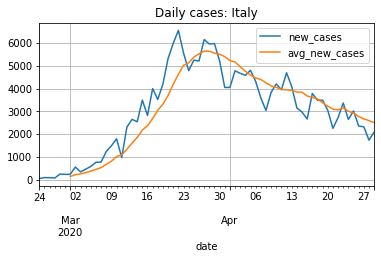

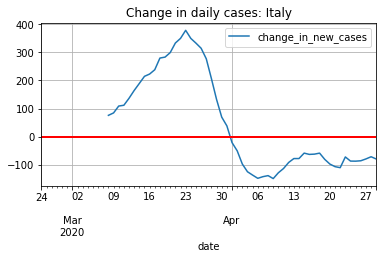

In [14]:
plot_country(fdf, 'Italy')

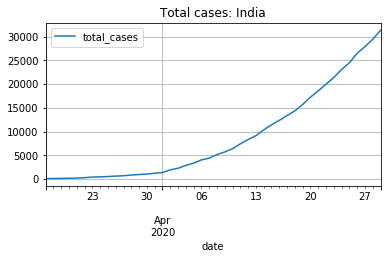

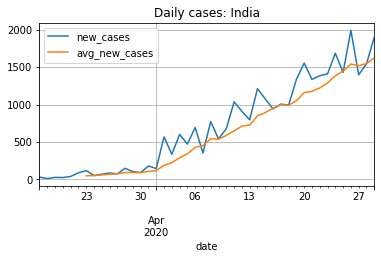

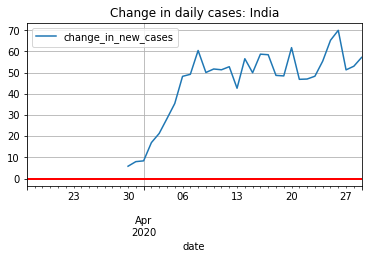

In [15]:
plot_country(fdf, "India")